## 1. 라이브러리 불러오기

In [3]:
import gymnasium as gym
from gymnasium import Env 
import numpy as np
from gymnasium.spaces import Box, Discrete

import random
random.seed(42)

## 2. 환경 만들기

In [4]:
def All_Cooperate(state, game_step): # 항상 협력
    return 1

def All_Cheat(state, game_step): # 항상 배신
    return 0

def Copycat(state, game_step): # 처음에는 협력 이후, 상대방의 전 전략을 따라함
    if game_step == 0:
        return 1
    else:
        return state[game_step-2]
    
def Grudger(state, game_step): # 항상 협력, 하지만 상대방이 한번이라도 배신하면 끝까지 배신
    for i in range(0, game_step-2+1, 2):        
        if state[i] == 0:            
            return 0
    return 1

def Detective(state, game_step): # 1-0-1-1으로 시작하고, 이 때 상대가 한번이라도 배신하면 Copycat 방식, 그렇지 않으면 All_Cheat 방식을 따른다.
    start = [1, -1, 0, -1, 1, -1, 1]
    if game_step <= 6:
        return start[game_step]
    
    for i in range(0, 7, 2):
        if state[i] == 0:
            return Copycat(state, game_step)
    return All_Cheat(state, game_step)

def Copykitten(state, game_step): # 첫번 째는 협력으로 시작한다. 상대가 두번연속 배신하면 배신한다.
    if game_step == 0 or game_step == 2:
        return 1
    elif state[game_step-2] == 0 and state[game_step-4] == 0:
        return 0
    return 1

def Simpleton(state, game_step): # 첫번 째는 협력으로 시작한다. 상대가 협력하면 내 마지막 수와 같은 수를, 상대가 배신하면 내 마지막 수와 다른 수를 둔다.    
    if game_step == 0:
        return 1
    elif state[game_step-2] == 1:
        return state[game_step-1]
    elif state[game_step-2] == 0:
        if state[game_step-1] == 1:
            return 0
        elif state[game_step-1] == 0:
            return 1
        
def Random_Game(state, game_step):
    return random.choice([0, 1])


In [28]:
class PrisonersGame(Env):
    def __init__(self):
        super().__init__()

        self.action_space = Discrete(2)
        self.observation_space = Box(low=-1, high=1, shape=(20,), dtype=np.int32)

        self.state = np.array([-1 for i in range(30)]).astype(np.int32)
        self.game_step = 0

        self.Opponent_Game_type = ["All_Cooperate", "All_Cheat", "Copycat", "Grudger", "Detective", "Copykitten", "Simpleton", "Random_Game"]  
        self.player = random.randint(0, 7)
    
    def get_observation(self):  
        return self.state
    
    def get_done(self):
        done=False
        if self.state[19] != -1:
            done = True
        return done

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([-1 for i in range(20)]).astype(np.int32)
        self.game_step = 0      
        self.player = random.randint(0, 7)

        obs = self.get_observation()
        info = {}
        return (obs, info)
    
    def step(self, action):

        self.state[self.game_step] = action              
        self.state[self.game_step+1] = eval(self.Opponent_Game_type[self.player])(self.state, self.game_step)
        
        reward = 0
        if self.state[self.game_step] == 1: # 나는 협력을 했는데
            if self.state[self.game_step+1] == 1: # 상대도 협력
                reward = +2
            elif self.state[self.game_step+1] == 1: # 상대는 배신
                reward = -1
        if self.state[self.game_step] == 0: # 나는 배신을 했는데
            if self.state[self.game_step+1] == 1: # 상대는 협력
                reward = +3
            elif self.state[self.game_step+1] == 0: # 상대도 배신
                reward = -0
        
        self.game_step += 2
        
        observation = self.get_observation()
        done = self.get_done() 
        truncated = False
        info = {}
        return observation, reward, truncated, done, info

    def step_select_op(self, num, action):
        self.state[self.game_step] = action
        self.state[self.game_step+1] = eval(self.Opponent_Game_type[num])(self.state, self.game_step)

        reward = 0
        if self.state[self.game_step] == 1: # 나는 협력을 했는데
            if self.state[self.game_step+1] == 1: # 상대도 협력
                reward = +2
            elif self.state[self.game_step+1] == 1: # 상대는 배신
                reward = -1
        if self.state[self.game_step] == 0: # 나는 배신을 했는데
            if self.state[self.game_step+1] == 1: # 상대는 협력
                reward = +3
            elif self.state[self.game_step+1] == 0: # 상대도 배신
                reward = -0
        
        self.game_step += 2
        
        observation = self.get_observation()
        done = self.get_done() 
        truncated = False
        info = {}
        return observation, reward, truncated, done, info

    def render(self):
        pass

In [29]:
env = PrisonersGame()

In [30]:
obs=env.get_observation()
print(obs)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


In [31]:
for episode in range(10):
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward, truncated, done, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))


Total Reward for episode 0 is 10
Total Reward for episode 1 is 18
Total Reward for episode 2 is 0
Total Reward for episode 3 is 20
Total Reward for episode 4 is 27
Total Reward for episode 5 is 5
Total Reward for episode 6 is 21
Total Reward for episode 7 is 22
Total Reward for episode 8 is 26
Total Reward for episode 9 is 21


## 3. 모델 만들기

In [32]:
from gymnasium.utils.env_checker import check_env

env = PrisonersGame()
check_env(env , warn = True , skip_render_check = True )

/Users/baesonghyeon/Documents/Project/prisoner's dilemma/venv/lib/python3.11/site-packages/gymnasium/utils/env_checker.py:270: UserWarning: WARN: `check_env(warn=...)` parameter is now ignored.
  logger.warn("`check_env(warn=...)` parameter is now ignored.")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 19.8     |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 9310     |
|    time_elapsed     | 0        |
|    total_timesteps  | 40       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 13.5     |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 9291     |
|    time_elapsed     | 0        |
|    total_timesteps  | 80       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 13.8   

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 11.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 32       |
|    fps              | 7929     |
|    time_elapsed     | 0        |
|    total_timesteps  | 320      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 12.1     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 36       |
|    fps              | 7812     |
|    time_elapsed     | 0        |
|    total_timesteps  | 360      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10       |
|    ep_rew_mean      | 12.6     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

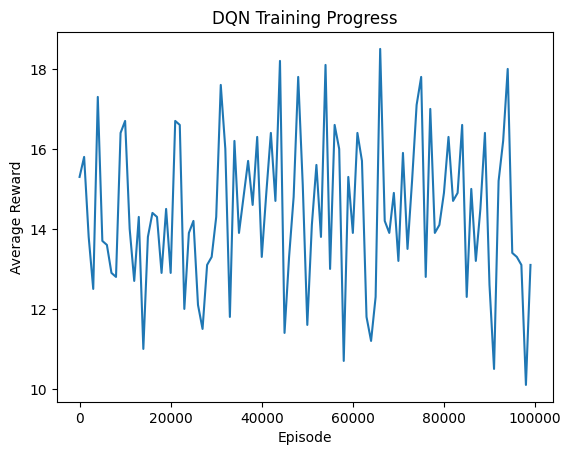

In [33]:
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

vec_env = PrisonersGame()
model = DQN("MlpPolicy", env, verbose=1, batch_size=100)
num_episodes = 100000
episode_rewards = [[], []]

def cal_average_reward():
    reward_li = []
    for i in range(20):
        obs, info = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, _states = model.predict(obs, deterministic=True)
            next_obs, reward, truncated, done, _ = env.step(action)
            total_reward += reward
            obs = next_obs
        reward_li.append(total_reward)
    return sum(reward_li)/len(reward_li)

for episode in range(0, num_episodes, 1000):

    model.learn(total_timesteps=1000, log_interval=4)
    episode_rewards[0].append(episode)
    average = cal_average_reward()
    episode_rewards[1].append(average)

model.save("./model/DQN_PrisonersGame")
del model

plt.plot(episode_rewards[0], episode_rewards[1])
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("DQN Training Progress")
plt.show()

In [41]:
model = DQN.load("./model/dqn_PrisonersGame")

obs, info = env.reset()
num = 0
total_reward = 0

for i in range(8):
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step_select_op(i, action)
        total_reward += reward

        if terminated or truncated:        
            print(env.Opponent_Game_type[i])
            print("result :", obs, "reward :", total_reward)
            
            obs, info = env.reset()    
            num += 1
            total_reward = 0
            break 

All_Cooperate
result : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] reward : 20
All_Cheat
result : [1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0] reward : 0
Copycat
result : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] reward : 20
Grudger
result : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] reward : 20
Detective
result : [1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0] reward : 6
Copykitten
result : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] reward : 20
Simpleton
result : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] reward : 20
Random_Game
result : [1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1] reward : 14
